# 10-year Yields through time

Equity investments are supposed to be for the "long-term." Usually, 10-years is where most investors peg their "long-term" to be. Investors have a choice between different asset classes - stocks/bonds/gold etc. With government/sovereign bonds, you know the yield (return) you can lock in, risk-free, for a decade today. Since equities are riskier, investors demand higher returns - the equity risk premium - over 10-year sovereign bond yields. This is why tracking the 10-year yield is important for equity investors - it denotes a floor for expected equity returns. Investors would be rational investors in equities only if they felt that it provides adequate excess returns over 10-year bonds.

Here, we plot the 10-year yields of US tresuries, Euro Area AAA rated soverigns and Indian Gsecs.

In [1]:
library(tidyverse)
library(ggthemes)
library(reshape2)
library(odbc)
library(plutoR)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

#initialize
indices <- Indices() #for IndiaGsecTimeSeries
ycurves <- YieldCurve() #for UsTreasury, EuroArea 

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘PerformanceAnalytics’

The following obje

In [2]:
startDate <- as.Date("2004-01-01")
# https://plutopy.readthedocs.io/en/latest/Indices.html#plutoPy.model.Indices.IndiaGsecTimeSeries
ycInd <- indices$IndiaGsecTimeSeries() %>%
    filter(NAME == "5_10" & TIME_STAMP >= startDate) %>%
    select(TIME_STAMP, YIELD = YTM) %>%
    collect() 

# https://plutopy.readthedocs.io/en/latest/YieldCurve.html#plutoPy.model.YieldCurve.UsTreasury
ycUst <- ycurves$UsTreasury() %>%
    filter(TIME_STAMP >= startDate) %>%
    select(TIME_STAMP, YIELD = Y10) %>%
    collect() 

# https://plutopy.readthedocs.io/en/latest/YieldCurve.html#plutoPy.model.YieldCurve.EuroArea
ycEuro <- ycurves$EuroArea() %>%
    filter(TENOR_Y == 10 & TENOR_M == 0 & CURVE_ID == 'G_N_A' & TIME_STAMP >= startDate) %>%
    select(TIME_STAMP, YIELD = VALUE) %>%
    collect() 

In [3]:
allYc <- ycInd %>% 
            left_join(ycUst, by=c('TIME_STAMP')) %>% 
            left_join(ycEuro, by=c('TIME_STAMP')) %>% 
            arrange(TIME_STAMP) %>%
            as.data.frame()

names(allYc) <- c('TIME_STAMP', 'INDIA', 'US', 'EURO')
print(head(allYc))
print(tail(allYc))

  TIME_STAMP  INDIA   US EURO
1 2004-01-01 5.1030   NA   NA
2 2004-01-02 5.0982 4.38   NA
3 2004-01-03 5.0870   NA   NA
4 2004-01-04 5.0856   NA   NA
5 2004-01-05 5.0996 4.41   NA
6 2004-01-06 5.0858 4.29   NA
     TIME_STAMP  INDIA   US       EURO
5670 2019-07-12 6.6476 2.12 -0.1802300
5671 2019-07-13 6.6472   NA         NA
5672 2019-07-14 6.6468   NA         NA
5673 2019-07-15 6.6163 2.09 -0.2239930
5674 2019-07-16 6.5579 2.13 -0.2301979
5675 2019-07-17 6.5730 2.06         NA


No id variables; using all as measure variables
Warning message:
“attributes are not identical across measure variables; they will be dropped”ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'TIME_STAMP' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         retur

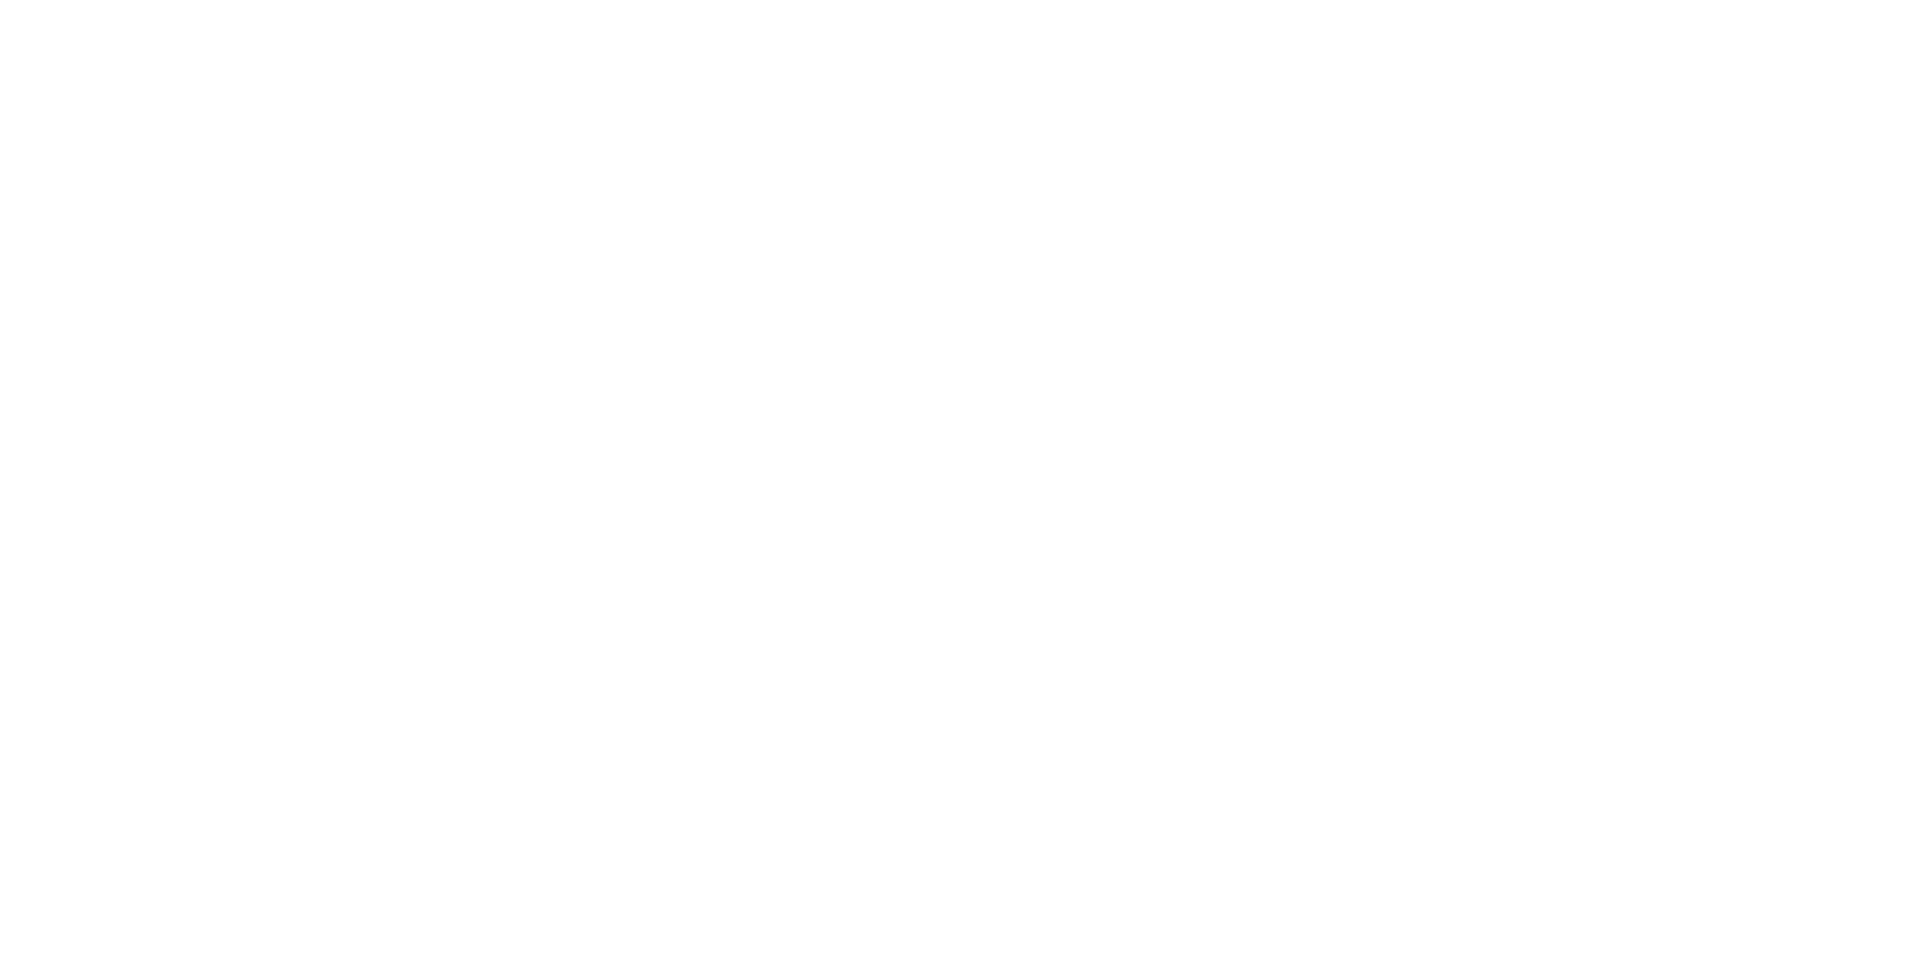

In [4]:
startDate <- first(allYc$TIME_STAMP)
endDate <- last(allYc$TIME_STAMP)

xAxisTicks <- seq(from=startDate, to=endDate, length.out=10)

toPlot <- melt(allYc, by='TIME_STAMP')

ggplot(toPlot, aes(x = TIME_STAMP, y=value, color=variable)) + 
    theme_economist() +
    geom_line() + 
    scale_x_date(breaks = xAxisTicks) +
    labs(x='', y='yield (%)', fill='', 
         title="10-year Sovereign Yields", 
         subtitle=sprintf("[%s:%s]", startDate, endDate)) +
    annotate("text", x=endDate, y=min(toPlot$value, na.rm=T), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)